In [143]:
# Importing all necessary libraries
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import backend as K

import numpy as np

img_width, img_height = 250, 250
test_size = 1/6

In [108]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [109]:
import shutil
import os
from sklearn.model_selection import train_test_split

emotion_folders = ['angry', 'disgusted', 'evil', 'fearful', 'happy', 'sad', 'surprised']

# Erase and create train/test folders
shutil.rmtree('Train')
shutil.rmtree('Test')
os.mkdir('Train')
os.mkdir('Test')

# Generate random train and test splits
for ef in emotion_folders:
    os.mkdir(f'Train/{ef}')
    os.mkdir(f'Test/{ef}')

    train_imgs, test_imgs = train_test_split(range(1, 7), test_size=test_size)
    for train in train_imgs:
        shutil.copyfile(f'Doodles/{ef}/{train}.png', f'Train/{ef}/{train}.png')
    for test in test_imgs:
        shutil.copyfile(f'Doodles/{ef}/{test}.png', f'Test/{ef}/{test}.png')


In [138]:
train_data_dir = 'Train/'
validation_data_dir = 'Test/'
nb_train_samples = round(42 * (1-test_size))
nb_validation_samples = round(42 * test_size)
epochs = 50
batch_size = 4


In [139]:
if K.image_data_format() == 'channels_first':
	input_shape = (3, img_width, img_height)
else:
	input_shape = (img_width, img_height, 3)


In [140]:
# Creating a Sequential model
model = Sequential([
    Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(img_width, img_height, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    
    Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    
    Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    
    Flatten(),
    
    Dense(units=256, activation='relu'),
    Dropout(0.5),
    Dense(units=7, activation='softmax')
])

In [141]:
model.compile(loss='categorical_crossentropy',
			optimizer=Adam(learning_rate=0.001),
			metrics=['accuracy'])


In [159]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

history = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=np.sqrt(0.1),
            patience=5
        ),
        EarlyStopping(
            monitor="val_loss",
            min_delta=0,
            patience=10,
            verbose=0,
            mode="auto",
            baseline=None,
            restore_best_weights=True,
            start_from_epoch=30,
        )]
)

Found 35 images belonging to 7 classes.
Found 7 images belonging to 7 classes.
Epoch 1/50
8/8 [==============================] - 1s 93ms/step - loss: 1.5262 - accuracy: 0.7097 - val_loss: 6.3138 - val_accuracy: 0.0000e+00 - lr: 3.1623e-06
Epoch 2/50
8/8 [==============================] - 1s 79ms/step - loss: 1.5096 - accuracy: 0.6774 - val_loss: 4.9048 - val_accuracy: 0.2500 - lr: 3.1623e-06
Epoch 3/50
8/8 [==============================] - 1s 78ms/step - loss: 1.1194 - accuracy: 0.7742 - val_loss: 7.9316 - val_accuracy: 0.0000e+00 - lr: 3.1623e-06
Epoch 4/50
8/8 [==============================] - 1s 85ms/step - loss: 1.7197 - accuracy: 0.6774 - val_loss: 7.7881 - val_accuracy: 0.0000e+00 - lr: 3.1623e-06
Epoch 5/50
8/8 [==============================] - 1s 80ms/step - loss: 1.8728 - accuracy: 0.7097 - val_loss: 8.5882 - val_accuracy: 0.2500 - lr: 3.1623e-06
Epoch 6/50
8/8 [==============================] - 1s 76ms/step - loss: 1.8080 - accuracy: 0.6452 - val_loss: 5.9374 - val_accurac

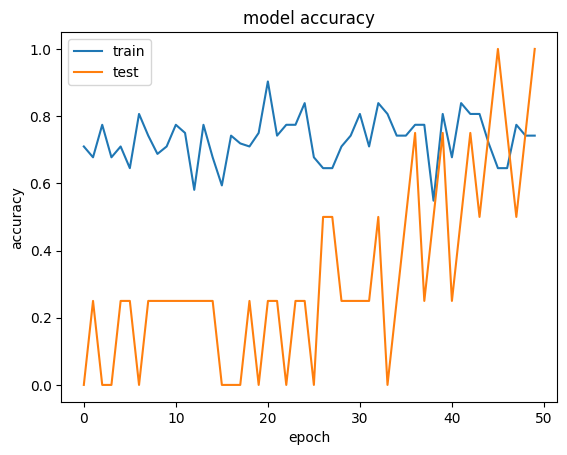

In [162]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [161]:
model.save('doodlemotion_model.keras')